In [1]:
import imageio
import numpy as np
import os 
import random
import matplotlib.pyplot as plt

In [2]:
#load data
files = os.listdir('YALE/centered')
pgm_files = [file for file in files if file.endswith(".pgm")]

#make a matrix of vectorized images
all_images_matrix = np.zeros((45045,1))

for file in pgm_files:
    if file.split('.')[1] in ['centerlight', 'happy', 'leftlight', 'rightlight', 'normal']:
        file_path = "YALE/centered/" + file
        image = imageio.imread(file_path).flatten().reshape(-1,1) 
        all_images_matrix = np.column_stack((all_images_matrix, image))

all_images_matrix = all_images_matrix[:, 1:]

#find averae face, covariance matrix, eigenvalues and eigenvectors 
average_face = np.mean(all_images_matrix, axis = 1)
average_face=average_face.reshape(-1,1)
centered_face_matrix = all_images_matrix - np.mean(all_images_matrix, axis = 1, keepdims=True)

cov_matrix = centered_face_matrix.transpose() @ centered_face_matrix
Eigenvalues, Eigenvectors = np.linalg.eig(cov_matrix)
Eigenvectors = Eigenvectors / np.linalg.norm(Eigenvectors, axis=0)
sorted_indices = np.argsort(Eigenvalues)[::-1]

C:\Users\riyos\AppData\Local\Temp\ipykernel_1456\203114921.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(file_path).flatten().reshape(-1,1)


In [3]:
#calculate accuracy (correctly identified/total test pictures) for different k values 
for k in [45,40,35,30,25,20,15,10,5,2]:

    eigenvalues = Eigenvalues[sorted_indices][:k]
    eigenvectors = Eigenvectors[:, sorted_indices][:k]

    #calculate eigenfaces
    actual_eigenvectors = []

    for ev in eigenvectors:
        ev = ev.reshape(-1,1)
        ev = centered_face_matrix @ ev
        actual_eigenvectors.append(ev)
    eigenfaces = np.hstack(actual_eigenvectors)
    eigenweights = eigenfaces.transpose() @ centered_face_matrix

    c = 0 #correctly identified pictures
    wrongly_identified = []

    #test all faces in the database
    for i in range(1, 16):
        if i < 10:
            subject_id = f'0{i}'
        else:
            subject_id = str(i)

        for setting in ['centerlight', 'rightlight', 'leftlight', 'normal', 'surprised', 'wink','glasses', 'noglasses', 'sad', 'happy']:
            query_path = f'YALE/centered/subject{subject_id}.{setting}.pgm'
            query = imageio.imread(query_path).flatten().reshape(-1, 1) - average_face
            query_w = eigenfaces.transpose() @ query

            
            e = np.linalg.norm(query_w - eigenweights, axis=0)
            j = np.argmin(e)
            s = int(j/5)+1

            if s == i: c+=1
            else: wrongly_identified.append(query_path)
        
    print(f'for k = {k}, accuracy % = {round(c/(c+len(wrongly_identified)), 2)*100}%, correct faces = {c}, wrong faces = {len(wrongly_identified)}')


C:\Users\riyos\AppData\Local\Temp\ipykernel_1456\3358100017.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  query = imageio.imread(query_path).flatten().reshape(-1, 1) - average_face


for k = 45, accuracy % = 95.0%, correct faces = 142, wrong faces = 8
for k = 40, accuracy % = 95.0%, correct faces = 142, wrong faces = 8
for k = 35, accuracy % = 95.0%, correct faces = 142, wrong faces = 8
for k = 30, accuracy % = 95.0%, correct faces = 142, wrong faces = 8
for k = 25, accuracy % = 93.0%, correct faces = 139, wrong faces = 11
for k = 20, accuracy % = 91.0%, correct faces = 137, wrong faces = 13
for k = 15, accuracy % = 88.0%, correct faces = 132, wrong faces = 18
for k = 10, accuracy % = 86.0%, correct faces = 129, wrong faces = 21
for k = 5, accuracy % = 77.0%, correct faces = 116, wrong faces = 34
for k = 2, accuracy % = 70.0%, correct faces = 105, wrong faces = 45


In [6]:
#sample query face matching
k = 10
eigenvalues = Eigenvalues[sorted_indices][:k]
eigenvectors = Eigenvectors[:, sorted_indices][:k]

#calculate eigenfaces
actual_eigenvectors = []

for ev in eigenvectors:
    ev = ev.reshape(-1,1)
    ev = centered_face_matrix @ ev
    actual_eigenvectors.append(ev)
eigenfaces = np.hstack(actual_eigenvectors)
eigenweights = eigenfaces.transpose() @ centered_face_matrix

#calculate query face vector 
query_image = 'YALE/centered/subject11.surprised.pgm'
query_image = imageio.imread(query_image).flatten().reshape(-1,1) - average_face
query_weights = eigenfaces.transpose() @ query_image

error = np.linalg.norm(query_weights - eigenweights, axis=0)
index = np.argmin(error)

subject = int(index/5)+1
print(f'Subject {subject} identified')
print(f'for k = {k}, min error = {error[index]}')

Subject 11 identified
for k = 10, min error = 120037895.40790822


C:\Users\riyos\AppData\Local\Temp\ipykernel_1456\361971146.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  query_image = imageio.imread(query_image).flatten().reshape(-1,1) - average_face


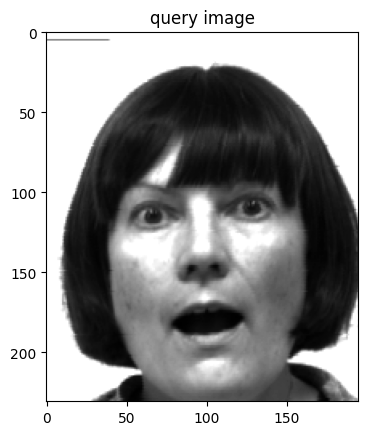

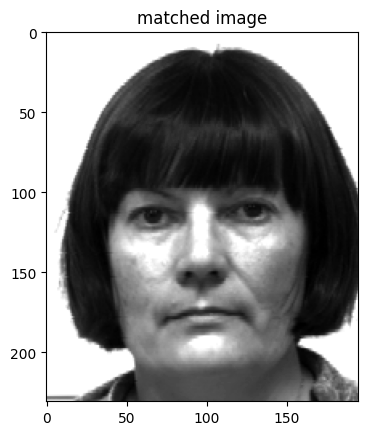

In [7]:
#display query_image
img = query_image + average_face
img = img.reshape(231, 195)
plt.imshow(img, cmap='gray')
plt.title("query image")
plt.show()

#display search result
result = all_images_matrix[:,index].reshape(231,195) 
plt.imshow(result, cmap='gray')
plt.title("matched image")
plt.show()

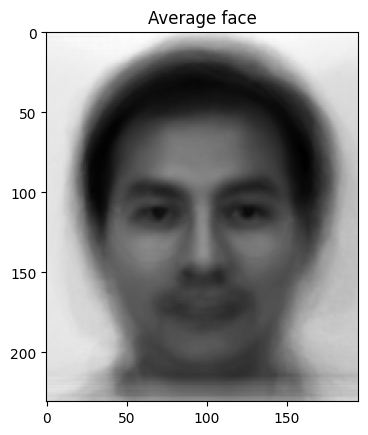

<Figure size 640x480 with 0 Axes>

In [6]:
#display average_face
average_face_image = average_face.reshape(231, 195)
plt.imshow(average_face_image, cmap='gray')
plt.title("Average face")
plt.show()
plt.savefig('AverageFace.png')

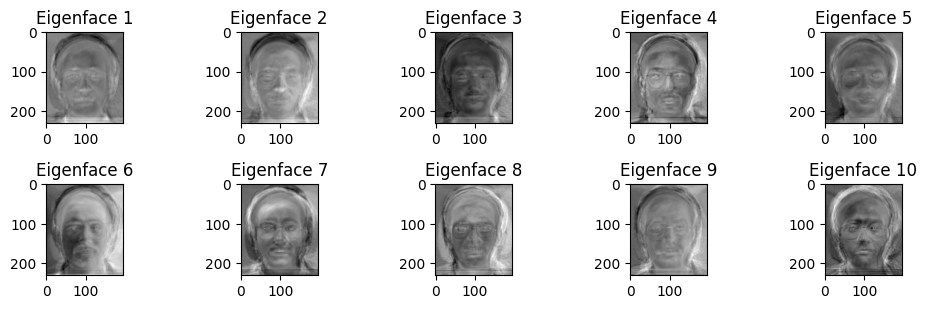

In [8]:
#plot eigenfaces
rows = 4  
cols = 5  

fig, axes = plt.subplots(rows, cols, figsize=(10, 6))

#Loop through Eigenfaces and plot them
for i in range(min(k, rows * cols)): 
    eigenface_image = eigenfaces[:, i].reshape(231, 195)

    row = i // cols
    col = i % cols

    axes[row, col].imshow(eigenface_image, cmap='gray')
    axes[row, col].set_title("Eigenface " + str(i + 1))

for i in range(k, rows * cols):
    row = i // cols
    col = i % cols
    fig.delaxes(axes[row, col])

plt.tight_layout()

# Show the plot
plt.show()


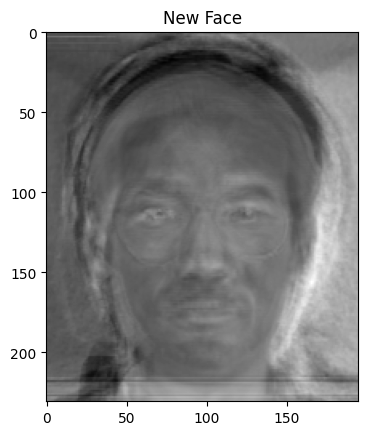

<Figure size 640x480 with 0 Axes>

In [22]:
new_face = (0.5*eigenfaces[:,3] + 0.25*eigenfaces[:,2] + 0.25*eigenfaces[:,1])
new_face_image = new_face.reshape(231, 195)
plt.imshow(new_face_image, cmap='gray')
plt.title("New Face")
plt.show()
plt.savefig('New face generated by linear combination of eigenfaces')


In [ ]:
#misc extra code

'''
av_subject_face = np.zeros((centered_face_matrix.shape[0], 15))
for i in range(0,15):
    av_subject_face[:,i-1] = np.mean(centered_face_matrix[:,5*i:5*i+5], axis = 1)
'''